In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8', errors='ignore')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = '/content/eng-odia.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'eng-odia.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: eng-odia.pkl
[sarojini naidu with mahatma gandhi] => [mahatma gandhinka saha sarojini naidu]
[is worlds oldest language of vedas] => [sanskrit heuchi biswara sarb puratana bhasha]
[numerical value] => [dedo]
[hrs] => [dedo ghanta]
[sursaravali] => [sursaravali]
[hrs] => [adhai ghanta]
[value] => [adhai]
[times is] => [thara heuchi]
[people sat] => [chari jana basipadila]
[a] => [gotea]
[a month has four weeks] => [gotie masare caroti saptaha thae]
[a boat capsized] => [eka danga budigala]
[a car hit tom] => [eka car tom ku dhakka deithila]
[a car went by] => [eka car gala]
[a child is sitting over there] => [saithi gote pila basichi]
[a few] => [alp kichi]
[a fish can swim] => [eka macha pahanripare]
[a list of plugins that are disabled by default] => [default bhabre akhyam hoithiba pluginagudikare eka talika]
[a little] => [tike]
[a man must work] => [jane byakti kama kariba jaruri]
[a man must work] => [mu ethare ekaki achi ki]
[a tress has roots branches leaves fruits and lif

In [18]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('/content/eng-odia.pkl')


# reduce dataset size
n_sentences = 5250
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:4500], dataset[4500:]
# save
save_clean_data(dataset, 'eng-odia-both.pkl')
save_clean_data(train, 'eng-odia-train.pkl')
save_clean_data(test, 'eng-odia-test.pkl')


Saved: eng-odia-both.pkl
Saved: eng-odia-train.pkl
Saved: eng-odia-test.pkl


In [19]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
# load datasets
dataset = load_clean_sentences('/content/eng-odia-both.pkl')
train = load_clean_sentences('/content/eng-odia-train.pkl')
test = load_clean_sentences('/content/eng-odia-test.pkl')
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [20]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [21]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare odia tokenizer
odia_tokenizer = create_tokenizer(dataset[:, 1])
odia_vocab_size = len(odia_tokenizer.word_index) + 1
odia_length = max_length(dataset[:, 1])
print('Odia Vocabulary Size: %d' % odia_vocab_size)
print('Odia Max Length: %d' % (odia_length))

English Vocabulary Size: 2451
English Max Length: 20
Odia Vocabulary Size: 3887
Odia Max Length: 20


In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

In [23]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [24]:
# prepare training data
trainX = encode_sequences(odia_tokenizer, odia_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(odia_tokenizer, odia_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 256)           995072    
                                                                 
 lstm_4 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_2 (RepeatVect  (None, 20, 256)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 20, 256)           525312    
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 2451)         629907    
 tributed)                                                       
                                                                 
Total params: 2,675,603
Trainable params: 2,675,603
No

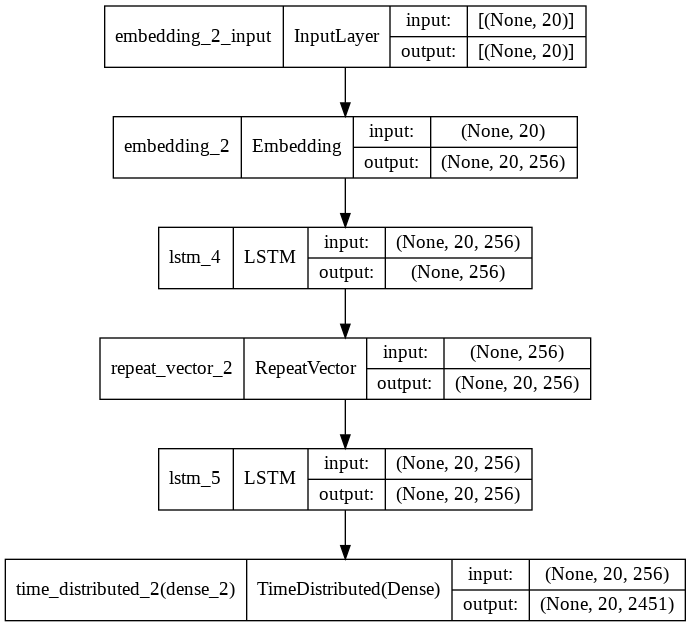

In [25]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(odia_vocab_size, eng_vocab_size, odia_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [26]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.24705, saving model to model.h5
71/71 - 35s - loss: 2.3703 - val_loss: 1.2470 - 35s/epoch - 487ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 1.24705 to 1.12231, saving model to model.h5
71/71 - 29s - loss: 1.1567 - val_loss: 1.1223 - 29s/epoch - 403ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 1.12231 to 1.02736, saving model to model.h5
71/71 - 28s - loss: 1.0149 - val_loss: 1.0274 - 28s/epoch - 398ms/step
Epoch 4/50

Epoch 00004: val_loss improved from 1.02736 to 0.99066, saving model to model.h5
71/71 - 28s - loss: 0.9393 - val_loss: 0.9907 - 28s/epoch - 401ms/step
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.99066
71/71 - 29s - loss: 0.9074 - val_loss: 1.0061 - 29s/epoch - 402ms/step
Epoch 6/50

Epoch 00006: val_loss did not improve from 0.99066
71/71 - 28s - loss: 0.8876 - val_loss: 0.9945 - 28s/epoch - 401ms/step
Epoch 7/50

Epoch 00007: val_loss did not improve from 0.99066
71/71 - 29s - los

In [27]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('/content/eng-odia-both.pkl')
train = load_clean_sentences('/content/eng-odia-train.pkl')
test = load_clean_sentences('/content/eng-odia-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
odia_tokenizer = create_tokenizer(dataset[:, 1])
odia_vocab_size = len(odia_tokenizer.word_index) + 1
odia_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(odia_tokenizer, odia_length, train[:, 1])
testX = encode_sequences(odia_tokenizer, odia_length, test[:, 1])

# load model
model = load_model('/content/model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[mu chadpatra hoichi], target=[im divorced], predicted=[im divorced]
src=[mu skiing pasand kare], target=[i like skiing], predicted=[i like skiing]
src=[kichi samaya apekhya kara], target=[wait a moment], predicted=[wait a moment]
src=[mu madhya samana chahuchi], target=[i want the same], predicted=[i want the same]
src=[anubandita], target=[affilliate], predicted=[affilliate]
src=[swikaar karantu], target=[admit], predicted=[admit]
src=[sabadhana ruha], target=[beware], predicted=[beware]
src=[kan karuchu], target=[what are you doing], predicted=[what are you doing]
src=[mu baseball pasand kare], target=[i like baseball], predicted=[i like cartoons]
src=[upaniyasha], target=[anectode], predicted=[anectode]
BLEU-1: 0.836342
BLEU-2: 0.744071
BLEU-3: 0.640654
BLEU-4: 0.384478
test
src=[dress kinibara achi ebe], target=[need to buy a dress now], predicted=[wait my bus]
src=[tom prarthana kole], target=[tom prayed], predicted=[tom prayed]
src=[mu khushi hebi], target=[ill be glad